To begin with we import neccessary library. Then, to prevent randomness while testing and evaluating, we set the random to 42


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import mixed_precision, backend as K
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, Flatten, ReLU, Add, GlobalAveragePooling2D)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                      ReduceLROnPlateau)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Run Configuration**:
To help spped up the traing and preperation process, we declare a general configuration which can be tuned for each specific run

In [ ]:
# Configuration
config = {
    "epochs": 1,
    "is_config_batch_size_param": True,
    "batch_size": 10,
    "initial_lr": 0.001,
    "gpu_memory_limit": 45,
    "target_size": (480, 640),
    "input_shape": (640, 480, 3), 
    "data_path": "Dataset/train_images",
    "csv_path": "processed_data/cleaned_imbalance_metadata_short.csv",
    "train_set_csv": "Result/resnet_rgb/resnet_rgb_train_set.csv",
    "val_set_csv": "Result/resnet_rgb/resnet_rgb_validation_set.csv",
    "best_model": "Result/resnet_rgb/resnet_rgb_best_model.keras",
    "label_encoder_path": "Result/resnet_rgb/resnet_rgb_label_encoder.npy",
    "save_dir": "Result/resnet_rgb",
}

**Set Up GPU**:
Next we set up the GPU for the run, choose the first one. This is because when renting runpod machine, it always appear as the first and only one.

In [15]:
# GPU Configuration
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def cleanup_gpu_memory():
    """Clear GPU memory and reset session"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

**Optimized batch size**:
To find the best batch size to fully ultilize the GPU, we use this function to predict the batch size. However, it can be by pass.

In [16]:
def calculate_max_batch_size(model, input_shape, gpu_mem=config["gpu_memory_limit"], default_batch=config["batch_size"], is_config_batch_size_param=config["is_config_batch_size_param"]):
    """Calculate optimal batch size based on GPU memory"""
    if not is_config_batch_size_param:
        return default_batch
    
    try:
        params = model.count_params()
        last_dense = next(layer for layer in reversed(model.layers) 
                         if isinstance(layer, tf.keras.layers.Dense))
        
        per_sample = ((params * 4) + (np.prod(input_shape) * last_dense.units * 4)) / (1024 ** 3)
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)
    except Exception as e:
        print(f"Using default batch size due to: {e}")
        return default_batch

**Load and Split the dataset**:
Initially, it encode the label. Then, it splits the dataset to training and validation dataset.

In [17]:
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with stratification"""
    df = pd.read_csv(config["csv_path"])
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
        np.save(config['label_encoder_path'], le.classes_)
    
    return train_df, val_df, le

**Apply Generator**:
The generator help feeding the data and perform augmentation to the image

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size=(480, 640), shuffle=False, debug=False, input_config=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        self.config = input_config if input_config else {}
        
        self.aug = A.Compose(input_config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # Original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # Augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label):
        img_path = os.path.join(self.base_path, label, image_id)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), *self.target_size[::-1], 3), dtype=np.float32)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((*self.target_size[::-1], 3), dtype=np.float32)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

**ResNet Model Simulation**:
Base on the ResNet model , we simulate its architect.

In [ ]:
def residual_block(x, filters, strides=1):
    shortcut = x
    
    x = Conv2D(filters, (3,3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=strides)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    return ReLU()(x)

def create_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype=tf.float32)
    
    x = Conv2D(64, (7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


**Training**:
In this function the dataset is splitted to train and validation dataframe. Batch size is optimized base on the GPU‌. Then the images is processed with the generator and use for fitting into training the model. We apply early stopping to stop if no update on validation accuracy, model checkpoint for restore and save the best wiehgt model, and gradually reduce learning rate on the process.

In [ ]:
def train(config, best_model_path):
    """Main training function"""
    cleanup_gpu_memory()
    train_df, val_df, le = load_and_preprocess_data()
    num_classes = len(le.classes_)
    
    model = create_resnet(config["input_shape"], num_classes)
    batch_size = calculate_max_batch_size(model, config["input_shape"], config["gpu_memory_limit"], config["batch_size"])
    
    train_gen = DataGenerator(train_df, config["data_path"], batch_size, config["target_size"], input_config=config, debug=True)
    val_gen = DataGenerator(val_df, config["data_path"], batch_size, config["target_size"], input_config=config, debug=False)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config["epochs"],
        callbacks=[
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
            ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)
        ]
    )
    
    return model, history


In [21]:
def plot_accuracy_loss(history):
    """Plot accuracy and loss"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

**Evalutation**: 
After gathering the model, we perform evaluation on the model to examine its effective, accuracy, and how stable it is when validating against the validation dataset.

In [ ]:
def evaluate_model(config, best_model_path, use_val_set=True):
    """Evaluate trained model"""
    cleanup_gpu_memory()
    le = LabelEncoder()
    le.classes_ = np.load(config['label_encoder_path'], allow_pickle=True)
    
    model = tf.keras.models.load_model(best_model_path)
    batch_size = calculate_max_batch_size(model, config["input_shape"], config["gpu_memory_limit"], config["batch_size"])
    
    eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
    eval_gen = DataGenerator(eval_df, config["data_path"], batch_size, config["target_size"], input_config=config, debug=False)
    
    results = model.evaluate(eval_gen, verbose=1, return_dict=True)
    
    # Collect predictions
    y_true, y_pred = [], []
    for i in range(len(eval_gen)):
        x, y = eval_gen[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, le.classes_, normalize=True)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    return results

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    fmt = '.2f' if normalize else 'd'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


**Execution**:
Execute the training and evaluating progress

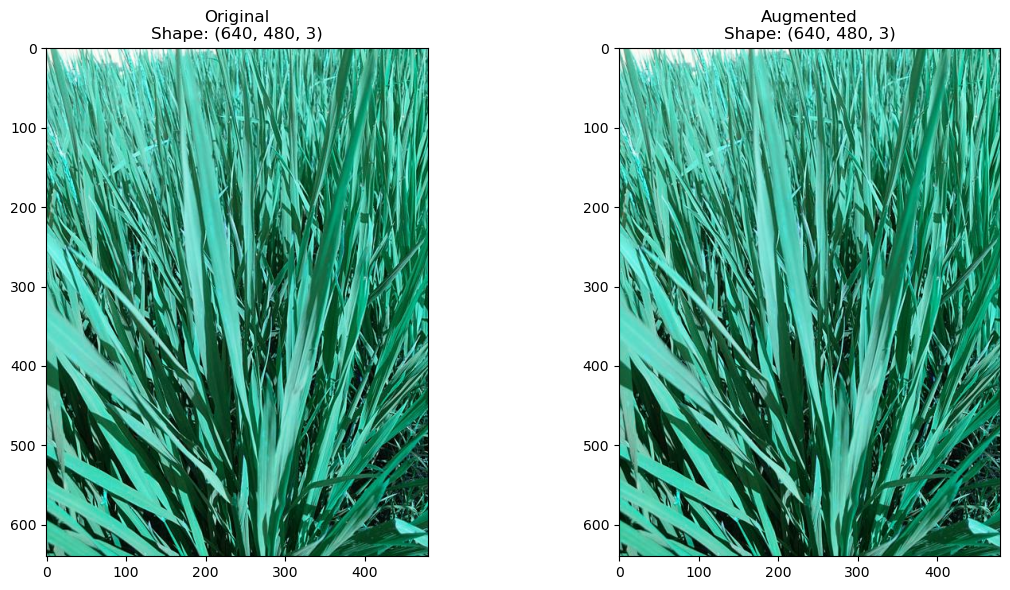

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 12s/step - accuracy: 0.2929 - loss: 148.9843 - val_accuracy: 0.1818 - val_loss: 11.3996 - learning_rate: 0.0010


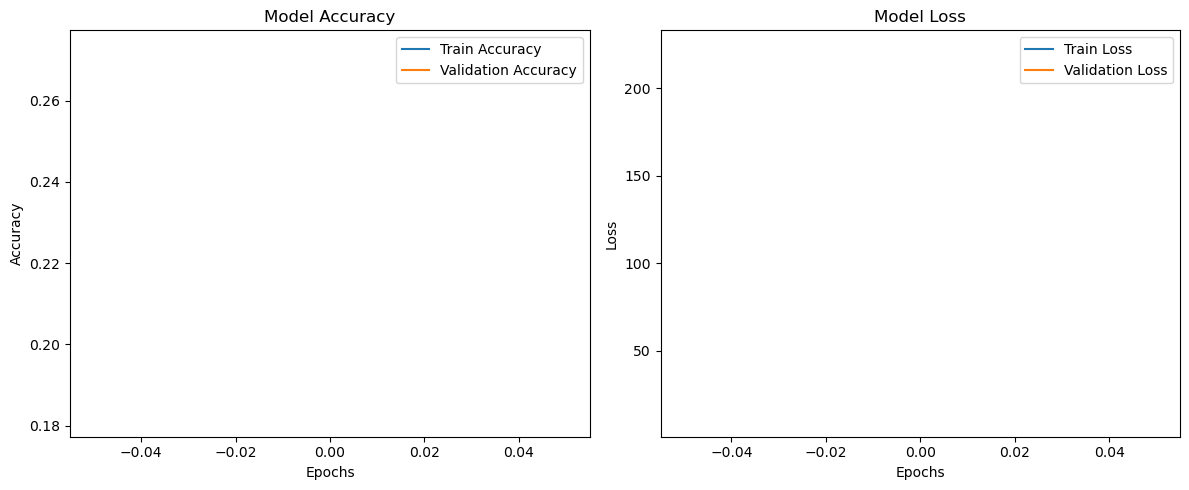

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.1818 - loss: 11.3996


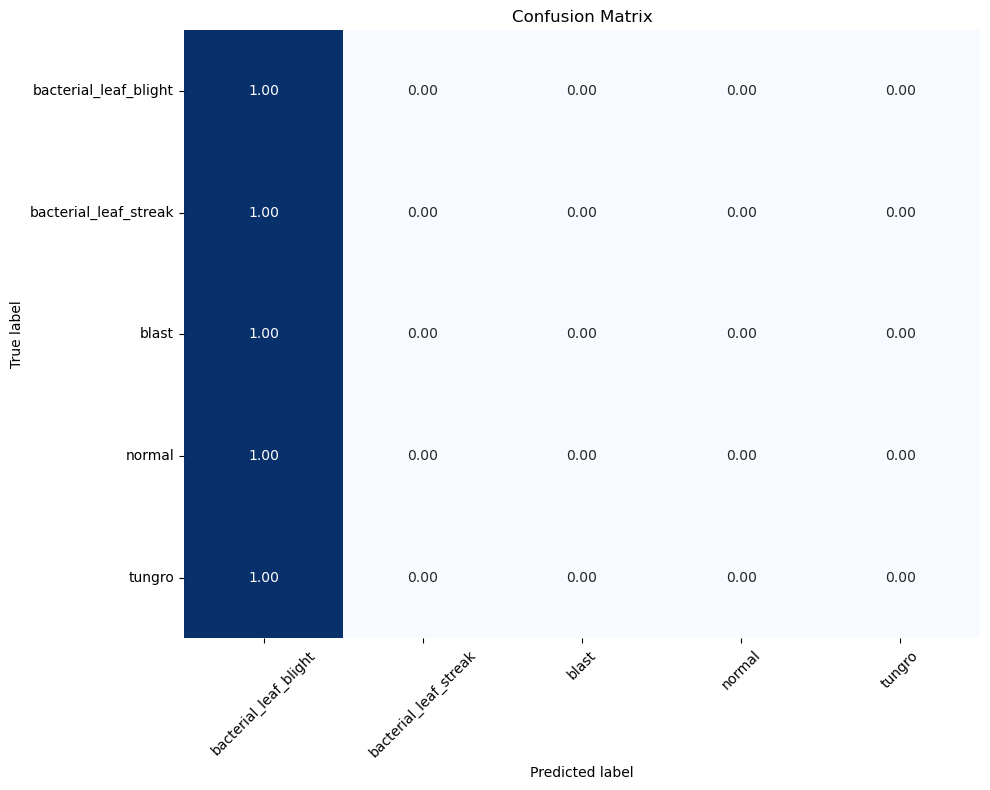


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.18      1.00      0.31         2
bacterial_leaf_streak       0.00      0.00      0.00         2
                blast       0.00      0.00      0.00         3
               normal       0.00      0.00      0.00         2
               tungro       0.00      0.00      0.00         2

             accuracy                           0.18        11
            macro avg       0.04      0.20      0.06        11
         weighted avg       0.03      0.18      0.06        11



/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
config_1 = {**config, "augmentation": [A.Resize(width=480, height=640)]}

best_model_dir_1 = os.path.join(config_1["save_dir"], "best_1.keras")
model_1, history_1 = train(config_1, best_model_dir_1)
plot_accuracy_loss(history_1)
evaluate_model(config_1, best_model_dir_1, use_val_set=True)

history_dir_1 = os.path.join(config_1["save_dir"], "history_1.csv")
history_df_1 = pd.DataFrame(history_1.history)
history_df_1.to_csv(history_dir_1, index=False)


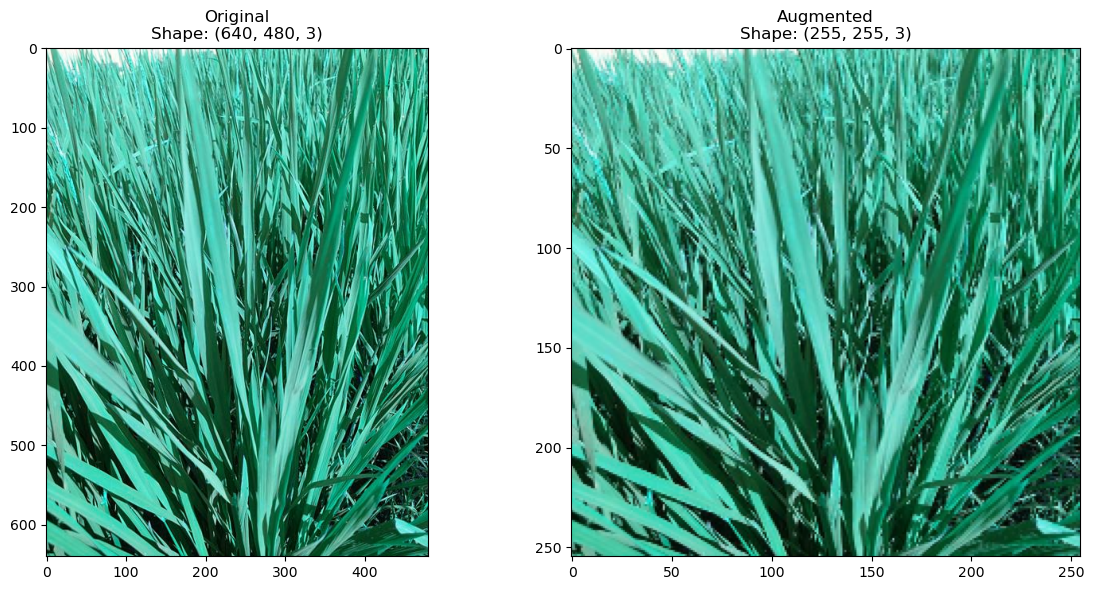

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2045 - loss: 2.2734 - val_accuracy: 0.2727 - val_loss: 9.2735 - learning_rate: 0.0010


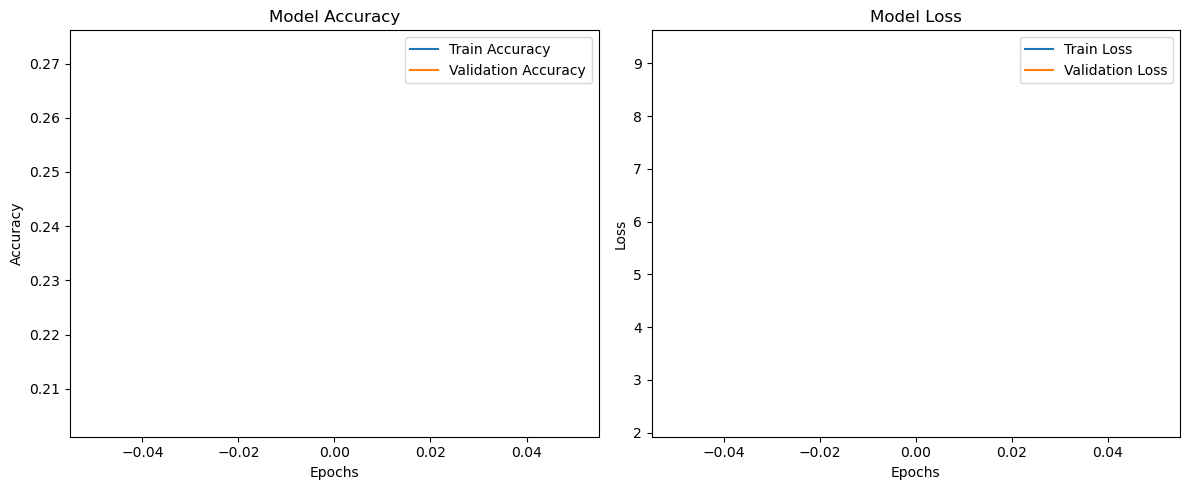

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2727 - loss: 9.2735


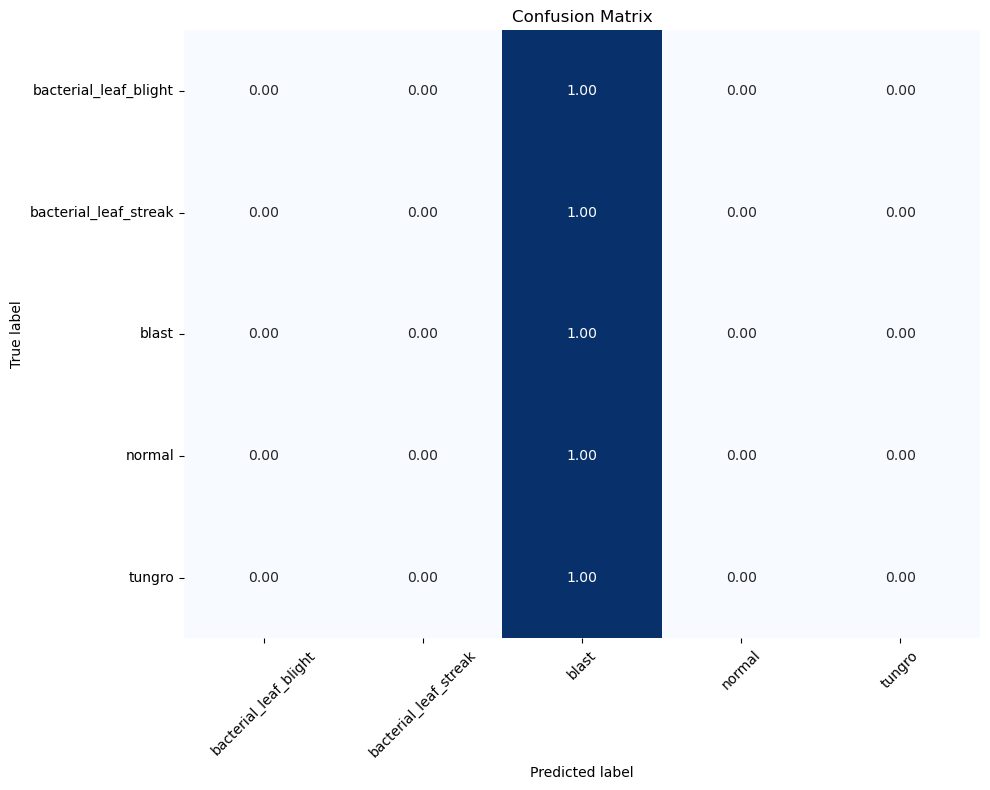


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.00      0.00      0.00         2
bacterial_leaf_streak       0.00      0.00      0.00         2
                blast       0.27      1.00      0.43         3
               normal       0.00      0.00      0.00         2
               tungro       0.00      0.00      0.00         2

             accuracy                           0.27        11
            macro avg       0.05      0.20      0.09        11
         weighted avg       0.07      0.27      0.12        11



/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
config_2 = {**config, "target_size": (255, 255), "input_shape": (255, 255, 3), "augmentation": [A.Resize(width=255, height=255),]}

best_model_dir_2 = os.path.join(config_2["save_dir"], "best_2.keras")
model_2, history_2 = train(config_2, best_model_dir_2)
plot_accuracy_loss(history_2)
evaluate_model(config_2, best_model_dir_2, use_val_set=True)

history_dir_2 = os.path.join(config_2["save_dir"],"history_2.csv")
history_df_2 = pd.DataFrame(history_2.history)
history_df_2.to_csv(history_dir_2, index=False)
